In [1]:
import Useful_functions as uf
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import scipy.stats as stats
from statsmodels.stats.weightstats import ttest_ind
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.decomposition import PCA
from pingouin import mediation_analysis
import seaborn as sns

/Users/luisalvarez/opt/anaconda3/lib/python3.9/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.2, the latest is 0.5.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [2]:
#pip install pingouin
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Look at scenarios at which similiarity effect is tangible

In [4]:
all_responses_filtered = pd.read_csv("all_responses_filtered.csv")

all_responses_filtered.head()

,Decoy,Item,Option_1,Option_2,Option_3,Choice,CatchTrials,Deliberation_RT,Choice_RT,Too_Slow,Survey_ID,CouplingCondition,PhantomCondition
0,F,Kitchen Scale,A,C,B,C,NaN,10000,620.0,0,40781,High coupling,Highly_desirable
1,C,Baby crib,C_A,B,A,A,NaN,10000,389.0,0,40781,High coupling,Highly_desirable
2,S,Baby high chair,A,B,S_B,B,NaN,10000,761.0,0,40781,High coupling,Highly_desirable
3,A,Leaf Blower,A,B,A_B,A,NaN,10000,308.0,0,40781,High coupling,Highly_desirable
4,P,Wifi extender,A,B,P_B,A,NaN,10000,586.0,0,40781,High coupling,Highly_desirable


In [88]:
all_responses_filtered[(all_responses_filtered["Survey_ID"] == 40781) & (all_responses_filtered["Decoy"] == "C")]["Choice_RT"].apply(float).mean()/1000




0.58435

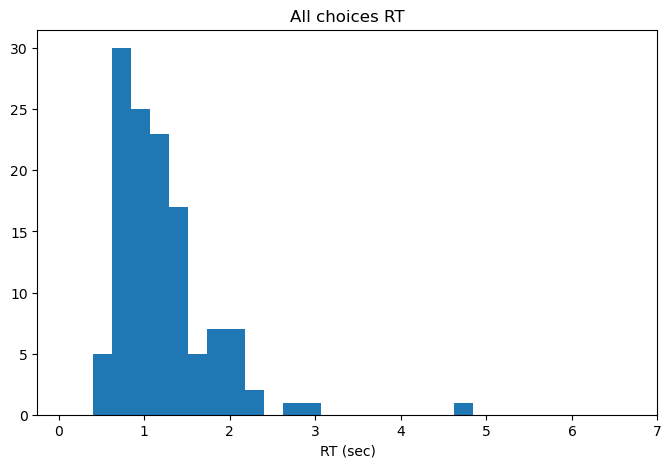

In [89]:
# Check participants RTs

group_rt_df = pd.DataFrame(columns=['PID', 'Mean_RT (sec)', 'Mean_RT_A', 'Mean_RT_C', 'Mean_RT_S'])
Participants_PIDs = all_responses_filtered["Survey_ID"].unique()

for x in Participants_PIDs:
    participant_pid = str(x)
    participant_rt = all_responses_filtered[all_responses_filtered["Survey_ID"] == x]["Choice_RT"].apply(float).mean()/1000
    participant_rt = round(participant_rt, 2)
    participant_rt_C = all_responses_filtered[(all_responses_filtered["Survey_ID"] == x) & (all_responses_filtered["Decoy"] == "C")]["Choice_RT"].apply(float).mean()/1000
    participant_rt_A = all_responses_filtered[(all_responses_filtered["Survey_ID"] == x) & (all_responses_filtered["Decoy"] == "A")]["Choice_RT"].apply(float).mean()/1000
    participant_rt_S = all_responses_filtered[(all_responses_filtered["Survey_ID"] == x) & (all_responses_filtered["Decoy"] == "S")]["Choice_RT"].apply(float).mean()/1000
    participant_rt_C = round(participant_rt_C, 2)
    participant_rt_A = round(participant_rt_A, 2)
    participant_rt_S = round(participant_rt, 2)
    current_p_df = pd.DataFrame(data={'PID': participant_pid, 'Mean_RT (sec)': participant_rt, 'Mean_RT_A': participant_rt_A, 'Mean_RT_C': participant_rt_C, 'Mean_RT_S': participant_rt_S}, index=range(1))
    group_rt_df = group_rt_df.append(current_p_df, ignore_index = True)

plt.subplots(figsize=(8, 5))
plt.hist(group_rt_df["Mean_RT (sec)"], bins=100)
plt.title('All choices RT')
plt.xlabel('RT (sec)')
plt.xlim(-.25, 7)
#plt.ylim(0, 28000)

plt.show()



In [90]:
group_rt_df
# join -> outer

,PID,Mean_RT (sec),Mean_RT_A,Mean_RT_C,Mean_RT_S
0,40781,0.56,0.50,0.58,0.56
1,40447,1.36,1.46,1.34,1.36
2,41454,0.90,0.69,0.70,0.90
3,34796,1.47,1.64,1.78,1.47
4,44066,0.84,0.70,1.08,0.84
...,...,...,...,...,...
120,44089,2.10,2.02,2.56,2.10
121,31535,1.76,1.87,2.02,1.76
122,37897,1.07,1.40,1.00,1.07
123,42986,1.14,0.84,2.28,1.14


In [6]:
# Define important variables (based on A_Preprocessing.ipynb)
total_n = 125

number_of_low_coupling = 61
number_of_high_coupling = 64

number_of_HD = 40
number_of_WD = 46
number_of_U = 39


## Similarity Decoy

In [7]:
decoy_S_df = all_responses_filtered[all_responses_filtered["Decoy"] == "S"]

# Filter out biased items.
similarity_biased_items = ["Baby high chair", "Metal detector", "Vacuum"]
decoy_S_df = decoy_S_df[~decoy_S_df.Item.isin(similarity_biased_items) == True]
# Removing biased items increases "Target(%)" 

decoy_S_df_LowC = decoy_S_df[decoy_S_df["CouplingCondition"] == "Low coupling"]
decoy_S_df_HighC = decoy_S_df[decoy_S_df["CouplingCondition"] == "High coupling"]
decoy_S_HD_df = decoy_S_df[decoy_S_df["PhantomCondition"] == "Highly_desirable"]
decoy_S_WD_df = decoy_S_df[decoy_S_df["PhantomCondition"] == "Weakly_desirable"]
decoy_S_U_df = decoy_S_df[decoy_S_df["PhantomCondition"] == "Undesirable"]

decoy_S_df = decoy_S_df.reset_index()
decoy_S_df_LowC = decoy_S_df_LowC.reset_index()
decoy_S_df_HighC = decoy_S_df_HighC.reset_index()
decoy_S_HD_df = decoy_S_HD_df.reset_index()
decoy_S_WD_df = decoy_S_WD_df.reset_index()
decoy_S_U_df = decoy_S_U_df.reset_index()

group_sim_freq_df = uf.partFreq_Decoy(decoy_S_df, "Sim_Decoy")
group_sim_freq_with_condition_df = uf.partFreq_DecoyWCondition(decoy_S_df, "Sim_Decoy")
group_sim_freq_df_LowC = uf.partFreq_Decoy(decoy_S_df_LowC, "Sim_Decoy")
group_sim_freq_df_HighC = uf.partFreq_Decoy(decoy_S_df_HighC, "Sim_Decoy")
group_sim_HD_freq_df = uf.partFreq_Decoy(decoy_S_HD_df, "Sim_Decoy")
group_sim_WD_freq_df = uf.partFreq_Decoy(decoy_S_WD_df, "Sim_Decoy")
group_sim_U_freq_df = uf.partFreq_Decoy(decoy_S_U_df, "Sim_Decoy")

participants_phantom_condition_arr = np.array(group_sim_freq_with_condition_df.PhantomCondition)

# Get mean, std, and sem for all participatns.
target_S_mean, target_S_std, target_S_sem = uf.get_decoy_stats(group_sim_freq_df, "Target(%)", total_n)
competitor_S_mean, competitor_S_std, competitor_S_sem = uf.get_decoy_stats(group_sim_freq_df, "Competitor(%)", total_n)
decoy_S_mean, decoy_S_std, decoy_S_sem = uf.get_decoy_stats(group_sim_freq_df, "Sim_Decoy(%)", total_n)

# Get mean, std, and sem for 'Low coupling' participatns.
target_S_LowC_mean, target_S_LowC_std, target_S_LowC_sem = uf.get_decoy_stats(group_sim_freq_df_LowC, "Target(%)", number_of_low_coupling)
competitor_S_LowC_mean, competitor_S_LowC_std, competitor_S_LowC_sem = uf.get_decoy_stats(group_sim_freq_df_LowC, "Competitor(%)", number_of_low_coupling)
decoy_S_LowC_mean, decoy_S_LowC_std, decoy_S_LowC_sem = uf.get_decoy_stats(group_sim_freq_df_LowC, "Sim_Decoy(%)", number_of_low_coupling)

# Get mean, std, and sem for 'High coupling' participatns.
target_S_HighC_mean, target_S_HighC_std, target_S_HighC_sem = uf.get_decoy_stats(group_sim_freq_df_HighC, "Target(%)", number_of_high_coupling)
competitor_S_HighC_mean, competitor_S_HighC_std, competitor_S_HighC_sem = uf.get_decoy_stats(group_sim_freq_df_HighC, "Competitor(%)", number_of_high_coupling)
decoy_S_HighC_mean, decoy_S_HighC_std, decoy_S_HighC_sem = uf.get_decoy_stats(group_sim_freq_df_HighC, "Sim_Decoy(%)", number_of_high_coupling)

# Get mean, std, and sem for 'Highly desirable' participatns.
target_S_HD_mean, target_S_HD_std, target_S_HD_sem = uf.get_decoy_stats(group_sim_HD_freq_df, "Target(%)", number_of_HD)
competitor_S_HD_mean, competitor_S_HD_std, competitor_S_HD_sem = uf.get_decoy_stats(group_sim_HD_freq_df, "Competitor(%)", number_of_HD)
decoy_S_HD_mean, decoy_S_HD_std, decoy_S_HD_sem = uf.get_decoy_stats(group_sim_HD_freq_df, "Sim_Decoy(%)", number_of_HD)

# Get mean, std, and sem for 'Weakly desirable' participatns.
target_S_WD_mean, target_S_WD_std, target_S_WD_sem = uf.get_decoy_stats(group_sim_WD_freq_df, "Target(%)", number_of_WD)
competitor_S_WD_mean, competitor_S_WD_std, competitor_S_WD_sem = uf.get_decoy_stats(group_sim_WD_freq_df, "Competitor(%)", number_of_WD)
decoy_S_WD_mean, decoy_S_WD_std, decoy_S_WD_sem = uf.get_decoy_stats(group_sim_WD_freq_df, "Sim_Decoy(%)", number_of_WD)

# Get mean, std, and sem for 'Undesirable' participatns.
target_S_U_mean, target_S_U_std, target_S_U_sem = uf.get_decoy_stats(group_sim_U_freq_df, "Target(%)", number_of_U)
competitor_S_U_mean, competitor_S_U_std, competitor_S_U_sem = uf.get_decoy_stats(group_sim_U_freq_df, "Competitor(%)", number_of_U)
decoy_S_U_mean, decoy_S_U_std, decoy_S_U_sem = uf.get_decoy_stats(group_sim_U_freq_df, "Sim_Decoy(%)", number_of_U)

# Show info for all groups.
Sim_summary_df = pd.DataFrame({'Target mean(%)': [target_S_mean, target_S_LowC_mean, target_S_HighC_mean, target_S_HD_mean, target_S_WD_mean, target_S_U_mean],
                  'Target sem(%)': [target_S_sem, target_S_LowC_sem, target_S_HighC_sem, target_S_HD_sem, target_S_WD_sem, target_S_U_sem],
                  'Comp mean(%)': [competitor_S_mean, competitor_S_LowC_mean, competitor_S_HighC_mean, competitor_S_HD_mean, competitor_S_WD_mean, competitor_S_U_mean],
                  'Comp sem(%)': [competitor_S_sem, competitor_S_LowC_sem, competitor_S_HighC_sem, competitor_S_HD_sem, competitor_S_WD_sem, competitor_S_U_sem],
                  'Decoy mean(%)': [decoy_S_mean, decoy_S_LowC_mean, decoy_S_HighC_mean, decoy_S_HD_mean, decoy_S_WD_mean, decoy_S_U_mean],
                  'Decoy sem(%)': [decoy_S_sem, decoy_S_LowC_sem, decoy_S_HighC_sem, decoy_S_HD_sem, decoy_S_WD_sem, decoy_S_U_sem]},
                  index=["All", "LowCoupling", "HighCoupling", "HighlyDesirable", "WeaklyDesirable", "Undesirable"])

Sim_summary_df.head(6)


,Target mean(%),Target sem(%),Comp mean(%),Comp sem(%),Decoy mean(%),Decoy sem(%)
All,53.94,1.56,22.57,1.16,23.49,1.02
LowCoupling,53.86,2.25,22.95,1.59,23.19,1.55
HighCoupling,54.02,2.19,22.21,1.69,23.77,1.36
HighlyDesirable,56.07,2.43,21.25,1.74,22.68,1.84
WeaklyDesirable,53.42,3.02,22.67,1.94,23.91,1.74
Undesirable,52.38,2.54,23.81,2.34,23.81,1.77


In [8]:
# Similarity Decoy results figure

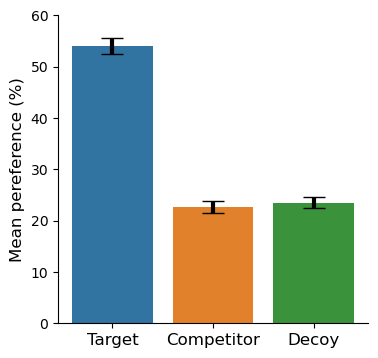

In [9]:
sim4seaborn = uf.format4seaborn(group_sim_freq_df, "Sim_Decoy(%)")

sns_y = np.array([target_S_mean, competitor_S_mean, decoy_S_mean])
sns_error = np.array([target_S_sem, competitor_S_sem, decoy_S_sem])

y_lim = [0, 60]

uf.seaborn_plot_classicdecoy(sns_y, sns_error, sim4seaborn, y_lim)

### Stat Analysis (Similarity Decoy)

In [10]:
# To get a different measure for Decoy effects. 

print("Runing a paired t-test between target and competitor choices: \n")

sim_t_test = stats.ttest_rel(group_sim_freq_df["Target(%)"], group_sim_freq_df["Competitor(%)"])

print("t-val: " + str(sim_t_test.statistic))
print("p-val: " + str(sim_t_test.pvalue))
print(f"p-val: {sim_t_test.pvalue:.50f}")


Runing a paired t-test between target and competitor choices: 

t-val: 12.282849910797635
p-val: 3.5337330478456186e-23
p-val: 0.00000000000000000000003533733047845618649034867520


In [11]:
#Check if the two samples have the same variance.
print("Check is there is a difference in targets relative choice \nshare between the 'Low couping' and the 'High coupling' groups.")

stat_sim_coup, p_sim_coup = stats.levene(group_sim_freq_df_LowC["Target(%)"], group_sim_freq_df_HighC["Target(%)"])

print("\np_sim_coup: " + str(p_sim_coup))
    
#Perform two sample t-test with equal variances
Sim_ttest_results = ttest_ind(group_sim_freq_df_LowC["Target(%)"], group_sim_freq_df_HighC["Target(%)"], alternative="two-sided", usevar="pooled")

print("SimDecoy High & Low Coupling: " + "\n t-stat: " + str(round(Sim_ttest_results[0], 3)) + "\n p-value: " + str(round(Sim_ttest_results[1], 3)) + "\n df: " + str(round(Sim_ttest_results[2], 3)))


Check is there is a difference in targets relative choice 
share between the 'Low couping' and the 'High coupling' groups.

p_sim_coup: 0.6080650732806911
SimDecoy High & Low Coupling: 
 t-stat: -0.049
 p-value: 0.961
 df: 123.0


### One-way ANOVA: Similarity scores and phantom desirability group 

In [12]:
print("Check if there is a difference between each phantom condition group, \n and the targets relative choice share.\n")

SimDecoy_PhanC_lm = ols('Target_perc ~ PhantomCondition', data=group_sim_freq_with_condition_df).fit()

SimDecoy_PhanC_table = sm.stats.anova_lm(SimDecoy_PhanC_lm)

SimDecoy_PhanC_table

Check if there is a difference between each phantom condition group, 
 and the targets relative choice share.



,df,sum_sq,mean_sq,F,PR(>F)
PhantomCondition,2.0,289.136350,144.568175,0.468896,0.626815
Residual,122.0,37614.537119,308.315878,NaN,NaN


### Two-way ANOVA: Similarity scores and (phantom desirability group & coupling condition group)


In [13]:
SimDecoy_PhanC_CoupC_lm = ols('Target_perc ~ PhantomCondition + CouplingCondition + PhantomCondition*CouplingCondition', data=group_sim_freq_with_condition_df).fit()

SimDecoy_PhanC_CoupC_table = sm.stats.anova_lm(SimDecoy_PhanC_CoupC_lm, type=2)

SimDecoy_PhanC_CoupC_table


,df,sum_sq,mean_sq,F,PR(>F)
PhantomCondition,2.0,289.136350,144.568175,0.474195,0.623557
CouplingCondition,1.0,0.098494,0.098494,0.000323,0.985690
PhantomCondition:CouplingCondition,2.0,1334.813116,667.406558,2.189146,0.116503
Residual,119.0,36279.625509,304.870803,NaN,NaN


## Compromise Decoy

In [14]:
decoy_C_df = all_responses_filtered[all_responses_filtered["Decoy"] == "C"]

# Filter out biased items.
compromise_biased_items = ["Mobility scooter", "Smart lock"]
decoy_C_df = decoy_C_df[~decoy_C_df.Item.isin(compromise_biased_items) == True]
# Removing items makes compromise effect stronger.

decoy_C_df_LowC = decoy_C_df[decoy_C_df["CouplingCondition"] == "Low coupling"]
decoy_C_df_HighC = decoy_C_df[decoy_C_df["CouplingCondition"] == "High coupling"]
decoy_C_HD_df = decoy_C_df[decoy_C_df["PhantomCondition"] == "Highly_desirable"]
decoy_C_WD_df = decoy_C_df[decoy_C_df["PhantomCondition"] == "Weakly_desirable"]
decoy_C_U_df = decoy_C_df[decoy_C_df["PhantomCondition"] == "Undesirable"]

decoy_C_df = decoy_C_df.reset_index()
decoy_C_df_LowC = decoy_C_df_LowC.reset_index()
decoy_C_df_HighC = decoy_C_df_HighC.reset_index()
decoy_C_HD_df = decoy_C_HD_df.reset_index()
decoy_C_WD_df = decoy_C_WD_df.reset_index()
decoy_C_U_df = decoy_C_U_df.reset_index()

group_com_freq_df = uf.partFreq_Decoy(decoy_C_df, "Com_Decoy")
group_com_freq_with_condition_df = uf.partFreq_DecoyWCondition(decoy_C_df, "Com_Decoy")
group_com_freq_df_LowC = uf.partFreq_Decoy(decoy_C_df_LowC, "Com_Decoy")
group_com_freq_df_HighC = uf.partFreq_Decoy(decoy_C_df_HighC, "Com_Decoy")
group_com_freq_HD_df = uf.partFreq_Decoy(decoy_C_HD_df, "Com_Decoy")
group_com_freq_WD_df = uf.partFreq_Decoy(decoy_C_WD_df, "Com_Decoy")
group_com_freq_U_df = uf.partFreq_Decoy(decoy_C_U_df, "Com_Decoy")

# Get mean, std, and sem for all participatns.
target_C_mean, target_C_std, target_C_sem = uf.get_decoy_stats(group_com_freq_df, "Target(%)", total_n)
competitor_C_mean, competitor_C_std, competitor_C_sem = uf.get_decoy_stats(group_com_freq_df, "Competitor(%)", total_n)
decoy_C_mean, decoy_C_std, decoy_C_sem = uf.get_decoy_stats(group_com_freq_df, "Com_Decoy(%)", total_n)

# Get mean, std, and sem for 'Low coupling' participatns.
target_C_LowC_mean, target_C_LowC_std, target_C_LowC_sem = uf.get_decoy_stats(group_com_freq_df_LowC, "Target(%)", number_of_low_coupling)
competitor_C_LowC_mean, competitor_C_LowC_std, competitor_C_LowC_sem = uf.get_decoy_stats(group_com_freq_df_LowC, "Competitor(%)", number_of_low_coupling)
decoy_C_LowC_mean, decoy_C_LowC_std, decoy_C_LowC_sem = uf.get_decoy_stats(group_com_freq_df_LowC, "Com_Decoy(%)", number_of_low_coupling)

# Get mean, std, and sem for 'High coupling' participatns.
target_C_HighC_mean, target_C_HighC_std, target_C_HighC_sem = uf.get_decoy_stats(group_com_freq_df_HighC, "Target(%)", number_of_high_coupling)
competitor_C_HighC_mean, competitor_C_HighC_std, competitor_C_HighC_sem = uf.get_decoy_stats(group_com_freq_df_HighC, "Competitor(%)", number_of_high_coupling)
decoy_C_HighC_mean, decoy_C_HighC_std, decoy_C_HighC_sem = uf.get_decoy_stats(group_com_freq_df_HighC, "Com_Decoy(%)", number_of_high_coupling)

# Get mean, std, and sem for 'Highly desirable' participatns.
target_C_HD_mean, target_C_HD_std, target_C_HD_sem = uf.get_decoy_stats(group_com_freq_HD_df, "Target(%)", number_of_HD)
competitor_C_HD_mean, competitor_C_HD_std, competitor_C_HD_sem = uf.get_decoy_stats(group_com_freq_HD_df, "Competitor(%)", number_of_HD)
decoy_C_HD_mean, decoy_C_HD_std, decoy_C_HD_sem = uf.get_decoy_stats(group_com_freq_HD_df, "Com_Decoy(%)", number_of_HD)

# Get mean, std, and sem for 'Weakly desirable' participatns.
target_C_WD_mean, target_C_WD_std, target_C_WD_sem = uf.get_decoy_stats(group_com_freq_WD_df, "Target(%)", number_of_WD)
competitor_C_WD_mean, competitor_C_WD_std, competitor_C_WD_sem = uf.get_decoy_stats(group_com_freq_WD_df, "Competitor(%)", number_of_WD)
decoy_C_WD_mean, decoy_C_WD_std, decoy_C_WD_sem = uf.get_decoy_stats(group_com_freq_WD_df, "Com_Decoy(%)", number_of_WD)

# Get mean, std, and sem for 'Undesirable' participatns.
target_C_U_mean, target_C_U_std, target_C_U_sem = uf.get_decoy_stats(group_com_freq_U_df, "Target(%)", number_of_U)
competitor_C_U_mean, competitor_C_U_std, competitor_C_U_sem = uf.get_decoy_stats(group_com_freq_U_df, "Competitor(%)", number_of_U)
decoy_C_U_mean, decoy_C_U_std, decoy_C_U_sem = uf.get_decoy_stats(group_com_freq_U_df, "Com_Decoy(%)", number_of_U)

# Show info for all groups.
Com_summary_df = pd.DataFrame({'Target mean(%)': [target_C_mean, target_C_LowC_mean, target_C_HighC_mean, target_C_HD_mean, target_C_WD_mean, target_C_U_mean],
                  'Target sem(%)': [target_C_sem, target_C_LowC_sem, target_C_HighC_sem, target_C_HD_sem, target_C_WD_sem, target_C_U_sem],
                  'Comp mean(%)': [competitor_C_mean, competitor_C_LowC_mean, competitor_C_HighC_mean, competitor_C_HD_mean, competitor_C_WD_mean, competitor_C_U_mean],
                  'Comp sem(%)': [competitor_C_sem, competitor_C_LowC_sem, competitor_C_HighC_sem, competitor_C_HD_sem, competitor_C_WD_sem, competitor_C_U_sem],
                  'Decoy mean(%)': [decoy_C_mean, decoy_C_LowC_mean, decoy_C_HighC_mean, decoy_C_HD_mean, decoy_C_WD_mean, decoy_C_U_mean],
                  'Decoy sem(%)': [decoy_C_sem, decoy_C_LowC_sem, decoy_C_HighC_sem, decoy_C_HD_sem, decoy_C_WD_sem, decoy_C_U_sem]},
                  index=["All", "LowCoupling", "HighCoupling", "HighlyDesirable", "WeaklyDesirable", "Undesirable"])

Com_summary_df.head(6)

,Target mean(%),Target sem(%),Comp mean(%),Comp sem(%),Decoy mean(%),Decoy sem(%)
All,66.40,1.60,22.60,1.08,11.00,0.85
LowCoupling,67.62,2.17,21.21,1.40,11.17,1.27
HighCoupling,65.23,2.36,23.93,1.63,10.84,1.15
HighlyDesirable,67.34,2.40,22.19,1.78,10.47,1.27
WeaklyDesirable,67.26,2.78,22.55,1.99,10.19,1.35
Undesirable,64.42,3.13,23.08,1.82,12.50,1.81


In [15]:
# Compromise decoy results figure

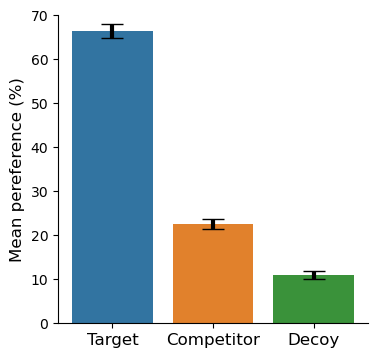

In [16]:
com4seaborn = uf.format4seaborn(group_com_freq_df, "Com_Decoy(%)")

sns_y = np.array([target_C_mean, competitor_C_mean, decoy_C_mean])
sns_error = np.array([target_C_sem, competitor_C_sem, decoy_C_sem])

y_lim = [0, 70]

uf.seaborn_plot_classicdecoy(sns_y, sns_error, com4seaborn, y_lim)

### Stat Analysis (Compromise Decoy)

In [17]:
print("Runing a paired t-test between target and competitor choices: \n")

com_t_test = stats.ttest_rel(group_com_freq_df["Target(%)"], group_com_freq_df["Competitor(%)"])

print("t-val: ", com_t_test.statistic)
print("p-val: " + str(com_t_test.pvalue))
print(f"p-val: {com_t_test.pvalue:.50f}")

Runing a paired t-test between target and competitor choices: 

t-val:  16.875673439132864
p-val: 6.465321109133697e-34
p-val: 0.00000000000000000000000000000000064653211091336970


In [18]:
### Check if the two samples have the same variance.
print("Check is there is a difference in targets relative choice \nshare between the 'Low couping' and the 'High coupling' groups.")

stat_com_coup, p_com_coup = stats.levene(group_com_freq_df_LowC["Target(%)"], group_com_freq_df_HighC["Target(%)"])

print("\np_com_coup: " + str(p_com_coup))
    
#Perform two sample t-test with equal variances
Com_ttest_results = ttest_ind(group_com_freq_df_LowC["Target(%)"], group_com_freq_df_HighC["Target(%)"], alternative="two-sided", usevar="pooled")

print("ComDecoy High & Low Coupling: " + "\n t-stat: " + str(round(Com_ttest_results[0], 3)) + "\n p-value: " + str(round(Com_ttest_results[1], 3)) + "\n df: " + str(round(Com_ttest_results[2], 3)))


Check is there is a difference in targets relative choice 
share between the 'Low couping' and the 'High coupling' groups.

p_com_coup: 0.2027372448910749
ComDecoy High & Low Coupling: 
 t-stat: 0.744
 p-value: 0.459
 df: 123.0


### One-way ANOVA: Compromise scores and phantom desirability group 

In [19]:

print("Check if there is a difference between each phantom condition group, \n and the targets relative choice share.\n")
ComDecoy_PhanC_lm = ols('Target_perc ~ PhantomCondition', data=group_com_freq_with_condition_df).fit()

ComDecoy_PhanC_table = sm.stats.anova_lm(ComDecoy_PhanC_lm)

ComDecoy_PhanC_table

Check if there is a difference between each phantom condition group, 
 and the targets relative choice share.



,df,sum_sq,mean_sq,F,PR(>F)
PhantomCondition,2.0,221.70869,110.854345,0.341557,0.71134
Residual,122.0,39595.79131,324.555666,NaN,NaN


### Two-way ANOVA: Compromise scores and (phantom desirability group & coupling condition group)


In [20]:
ComDecoy_PhanC_CoupC_lm = ols('Target_perc ~ PhantomCondition + CouplingCondition + PhantomCondition*CouplingCondition', data=group_com_freq_with_condition_df).fit()

ComDecoy_PhanC_CoupC_table = sm.stats.anova_lm(ComDecoy_PhanC_CoupC_lm)

ComDecoy_PhanC_CoupC_table

,df,sum_sq,mean_sq,F,PR(>F)
PhantomCondition,2.0,221.708690,110.854345,0.342359,0.710790
CouplingCondition,1.0,260.945692,260.945692,0.805897,0.371149
PhantomCondition:CouplingCondition,2.0,803.203198,401.601599,1.240295,0.293011
Residual,119.0,38531.642420,323.795314,NaN,NaN


## Attraction Decoy

In [21]:
decoy_A_df = all_responses_filtered[all_responses_filtered["Decoy"] == "A"]

# Filter out biased items.
attraction_biased_items = ["Car seat", "Leaf Blower", "Rash cream", "Slow cooker", "Tire inflator"]
decoy_A_df = decoy_A_df[~decoy_A_df.Item.isin(attraction_biased_items) == True]
# Filtering out biased items increases a bit attraction effect.

decoy_A_df_LowC = decoy_A_df[decoy_A_df["CouplingCondition"] == "Low coupling"]
decoy_A_df_HighC = decoy_A_df[decoy_A_df["CouplingCondition"] == "High coupling"]
decoy_A_HD_df = decoy_A_df[decoy_A_df["PhantomCondition"] == "Highly_desirable"]
decoy_A_WD_df = decoy_A_df[decoy_A_df["PhantomCondition"] == "Weakly_desirable"]
decoy_A_U_df = decoy_A_df[decoy_A_df["PhantomCondition"] == "Undesirable"]

decoy_A_df = decoy_A_df.reset_index()
decoy_A_df_LowC = decoy_A_df_LowC.reset_index()
decoy_A_df_HighC = decoy_A_df_HighC.reset_index()
decoy_A_HD_df = decoy_A_HD_df.reset_index()
decoy_A_WD_df = decoy_A_WD_df.reset_index()
decoy_A_U_df = decoy_A_U_df.reset_index()

group_att_freq_df = uf.partFreq_Decoy(decoy_A_df, "Att_Decoy")
group_att_freq_with_condition_df = uf.partFreq_DecoyWCondition(decoy_A_df, "Att_Decoy")
group_att_freq_df_LowC = uf.partFreq_Decoy(decoy_A_df_LowC, "Att_Decoy")
group_att_freq_df_HighC = uf.partFreq_Decoy(decoy_A_df_HighC, "Att_Decoy")
group_att_freq_HD_df = uf.partFreq_Decoy(decoy_A_HD_df, "Att_Decoy")
group_att_freq_WD_df = uf.partFreq_Decoy(decoy_A_WD_df, "Att_Decoy")
group_att_freq_U_df = uf.partFreq_Decoy(decoy_A_U_df, "Att_Decoy")

# Get mean, std, and sem for all participatns.
target_A_mean, target_A_std, target_A_sem = uf.get_decoy_stats(group_att_freq_df, "Target(%)", total_n)
competitor_A_mean, competitor_A_std, competitor_A_sem = uf.get_decoy_stats(group_att_freq_df, "Competitor(%)", total_n)
decoy_A_mean, decoy_A_std, decoy_A_sem = uf.get_decoy_stats(group_att_freq_df, "Att_Decoy(%)", total_n)

# Get mean, std, and sem for 'Low coupling' participatns.
target_A_LowC_mean, target_A_LowC_std, target_A_LowC_sem = uf.get_decoy_stats(group_att_freq_df_LowC, "Target(%)", number_of_low_coupling)
competitor_A_LowC_mean, competitor_A_LowC_std, competitor_A_LowC_sem = uf.get_decoy_stats(group_att_freq_df_LowC, "Competitor(%)", number_of_low_coupling)
decoy_A_LowC_mean, decoy_A_LowC_std, decoy_A_LowC_sem = uf.get_decoy_stats(group_att_freq_df_LowC, "Att_Decoy(%)", number_of_low_coupling)

# Get mean, std, and sem for 'High coupling' participatns.
target_A_HighC_mean, target_A_HighC_std, target_A_HighC_sem = uf.get_decoy_stats(group_att_freq_df_HighC, "Target(%)", number_of_high_coupling)
competitor_A_HighC_mean, competitor_A_HighC_std, competitor_A_HighC_sem = uf.get_decoy_stats(group_att_freq_df_HighC, "Competitor(%)", number_of_high_coupling)
decoy_A_HighC_mean, decoy_A_HighC_std, decoy_A_HighC_sem = uf.get_decoy_stats(group_att_freq_df_HighC, "Att_Decoy(%)", number_of_high_coupling)

# Get mean, std, and sem for 'Highly desirable' participatns.
target_A_HD_mean, target_A_HD_std, target_A_HD_sem = uf.get_decoy_stats(group_att_freq_HD_df, "Target(%)", number_of_HD)
competitor_A_HD_mean, competitor_A_HD_std, competitor_A_HD_sem = uf.get_decoy_stats(group_att_freq_HD_df, "Competitor(%)", number_of_HD)
decoy_A_HD_mean, decoy_A_HD_std, decoy_A_HD_sem = uf.get_decoy_stats(group_att_freq_HD_df, "Att_Decoy(%)", number_of_HD)

# Get mean, std, and sem for 'Weakly desirable' participatns.
target_A_WD_mean, target_A_WD_std, target_A_WD_sem = uf.get_decoy_stats(group_att_freq_WD_df, "Target(%)", number_of_WD)
competitor_A_WD_mean, competitor_A_WD_std, competitor_A_WD_sem = uf.get_decoy_stats(group_att_freq_WD_df, "Competitor(%)", number_of_WD)
decoy_A_WD_mean, decoy_A_WD_std, decoy_A_WD_sem = uf.get_decoy_stats(group_att_freq_WD_df, "Att_Decoy(%)", number_of_WD)

# Get mean, std, and sem for 'Undesirable' participatns.
target_A_U_mean, target_A_U_std, target_A_U_sem = uf.get_decoy_stats(group_att_freq_U_df, "Target(%)", number_of_U)
competitor_A_U_mean, competitor_A_U_std, competitor_A_U_sem = uf.get_decoy_stats(group_att_freq_U_df, "Competitor(%)", number_of_U)
decoy_A_U_mean, decoy_A_U_std, decoy_A_U_sem = uf.get_decoy_stats(group_att_freq_U_df, "Att_Decoy(%)", number_of_U)

# Show info for all groups.
Att_summary_df = pd.DataFrame({'Target mean(%)': [target_A_mean, target_A_LowC_mean, target_A_HighC_mean, target_A_HD_mean, target_A_WD_mean, target_A_U_mean],
                  'Target sem(%)': [target_A_sem, target_A_LowC_sem, target_A_HighC_sem, target_A_HD_sem, target_A_WD_sem, target_A_U_sem],
                  'Comp mean(%)': [competitor_A_mean, competitor_A_LowC_mean, competitor_A_HighC_mean, competitor_A_HD_mean, competitor_A_WD_mean, competitor_A_U_mean],
                  'Comp sem(%)': [competitor_A_sem, competitor_A_LowC_sem, competitor_A_HighC_sem, competitor_A_HD_sem, competitor_A_WD_sem, competitor_A_U_sem],
                  'Decoy mean(%)': [decoy_A_mean, decoy_A_LowC_mean, decoy_A_HighC_mean, decoy_A_HD_mean, decoy_A_WD_mean, decoy_A_U_mean],
                  'Decoy sem(%)': [decoy_A_sem, decoy_A_LowC_sem, decoy_A_HighC_sem, decoy_A_HD_sem, decoy_A_WD_sem, decoy_A_U_sem]},
                  index=["All", "LowCoupling", "HighCoupling", "HighlyDesirable", "WeaklyDesirable", "Undesirable"])

Att_summary_df.head(6)

,Target mean(%),Target sem(%),Comp mean(%),Comp sem(%),Decoy mean(%),Decoy sem(%)
All,61.28,1.57,26.88,1.37,11.84,1.19
LowCoupling,60.00,2.47,27.38,1.97,12.62,2.04
HighCoupling,62.50,1.98,26.41,1.93,11.09,1.30
HighlyDesirable,62.75,2.82,25.50,2.40,11.75,1.68
WeaklyDesirable,58.91,2.70,26.52,2.43,14.57,2.50
Undesirable,62.56,2.67,28.72,2.30,8.72,1.65


In [22]:
# Attraction decoy results figure

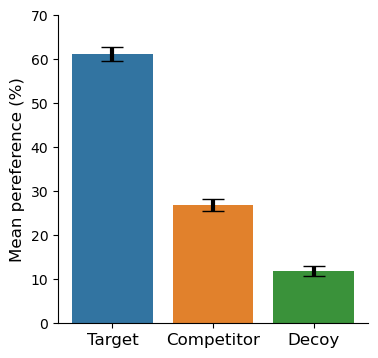

In [23]:
att4seaborn = uf.format4seaborn(group_att_freq_df, "Att_Decoy(%)")

sns_y = np.array([target_A_mean, competitor_A_mean, decoy_A_mean])
sns_error = np.array([target_A_sem, competitor_A_sem, decoy_A_sem])

y_lim = [0, 70]

uf.seaborn_plot_classicdecoy(sns_y, sns_error, att4seaborn, y_lim)

### Stat Analysis (Attraction Decoy)

In [24]:
# To get a different measure for Decoy effects. 

print("Runing a paired t-test between target and competitor choices: \n")

att_t_test = stats.ttest_rel(group_att_freq_df["Target(%)"], group_att_freq_df["Competitor(%)"])

print("t-val: " + str(att_t_test.statistic))
print("p-val: " + str(att_t_test.pvalue))
print(f"p-val: {att_t_test.pvalue:.40f}")


Runing a paired t-test between target and competitor choices: 

t-val: 12.724703497372548
p-val: 3.0226622427122816e-24
p-val: 0.0000000000000000000000030226622427122816


In [25]:
#Check if the two samples have the same variance.
print("Check is there is a difference in targets relative choice \nshare between the 'Low couping' and the 'High coupling' groups.")

stat_att_coup, p_att_coup = stats.levene(group_att_freq_df_LowC["Target(%)"], group_att_freq_df_HighC["Target(%)"])

print("\np_att_coup: " + str(round(p_att_coup, 3)))
    
#Perform two sample t-test with equal variances
Att_ttest_results = ttest_ind(group_att_freq_df_LowC["Target(%)"], group_att_freq_df_HighC["Target(%)"], alternative="two-sided", usevar="pooled")

print("AttDecoy High & Low Coupling: " + "\n t-stat: " + str(round(Att_ttest_results[0], 3)) + "\n p-value: " + str(round(Att_ttest_results[1], 3)) + "\n df: " + str(round(Att_ttest_results[2], 3)))


Check is there is a difference in targets relative choice 
share between the 'Low couping' and the 'High coupling' groups.

p_att_coup: 0.529
AttDecoy High & Low Coupling: 
 t-stat: -0.793
 p-value: 0.429
 df: 123.0


In [26]:
# One-way ANOVA w/ statsmodels
print("Check if there is a difference between each phantom condition group, \n and the targets relative choice share.\n")

AttDecoy_PhanC_lm = ols('Target_perc ~ PhantomCondition', data=group_att_freq_with_condition_df).fit()

AttDecoy_PhanC_table = sm.stats.anova_lm(AttDecoy_PhanC_lm)

AttDecoy_PhanC_table

Check if there is a difference between each phantom condition group, 
 and the targets relative choice share.



,df,sum_sq,mean_sq,F,PR(>F)
PhantomCondition,2.0,408.458082,204.229041,0.655912,0.520789
Residual,122.0,37986.741918,311.366737,NaN,NaN


### Two-way ANOVA: Attraction scores and (phantom desirability group & coupling condition group)


In [27]:
AttDecoy_PhanC_CoupC_lm = ols('Target_perc ~ PhantomCondition + CouplingCondition + PhantomCondition*CouplingCondition', data=group_att_freq_with_condition_df).fit()

AttDecoy_PhanC_CoupC_table = sm.stats.anova_lm(AttDecoy_PhanC_CoupC_lm)

AttDecoy_PhanC_CoupC_table

,df,sum_sq,mean_sq,F,PR(>F)
PhantomCondition,2.0,408.458082,204.229041,0.649451,0.524174
CouplingCondition,1.0,294.341691,294.341691,0.936010,0.335268
PhantomCondition:CouplingCondition,2.0,271.159625,135.579812,0.431145,0.650775
Residual,119.0,37421.240602,314.464207,NaN,NaN


## Correlation between Classic Decoys

In [28]:
similarity_scores_all = []
compromise_Scores_all = []
attention_scores_all = []

for x in Participants_PIDs: 
    
    similarity_scrore = group_sim_freq_df[group_sim_freq_df["PID"] == x]["Competitor(%)"]/(group_sim_freq_df[group_sim_freq_df["PID"] == x]["Competitor(%)"] + group_sim_freq_df[group_sim_freq_df["PID"] == x]["Target(%)"])
    
    compromise_score = group_com_freq_df[group_com_freq_df["PID"] == x]["Target(%)"]/(group_com_freq_df[group_com_freq_df["PID"] == x]["Target(%)"] + group_com_freq_df[group_com_freq_df["PID"] == x]["Competitor(%)"])
    
    attention_score = group_att_freq_df[group_att_freq_df["PID"] == x]["Target(%)"]/(group_att_freq_df[group_att_freq_df["PID"] == x]["Target(%)"] + group_att_freq_df[group_att_freq_df["PID"] == x]["Competitor(%)"])
    
    similarity_scores_all.append(similarity_scrore)
    
    compromise_Scores_all.append(compromise_score)
    
    attention_scores_all.append(attention_score)
    
similarity_scores_all = np.array(similarity_scores_all)
compromise_Scores_all = np.array(compromise_Scores_all)
attention_scores_all = np.array(attention_scores_all)

all_classic_decoys_df = pd.DataFrame(data={'Similarity': similarity_scores_all.flatten(),
                  'Compromise': compromise_Scores_all.flatten(),
                  'Attraction': attention_scores_all.flatten()}, index=range(total_n))



all_classic_decoys_df = all_classic_decoys_df.fillna(0)
all_classic_decoys_df.head()


,Similarity,Compromise,Attraction
0,0.000000,0.928571,0.777778
1,0.400000,0.466667,0.444444
2,0.181818,0.692308,0.600000
3,0.230769,0.785714,0.625000
4,0.363636,0.937500,0.700000


In [29]:
corr_sim_com = stats.pearsonr(all_classic_decoys_df["Similarity"], all_classic_decoys_df["Compromise"])
corr_sim_att = stats.pearsonr(all_classic_decoys_df["Similarity"], all_classic_decoys_df["Attraction"])
corr_att_com = stats.pearsonr(all_classic_decoys_df["Attraction"], all_classic_decoys_df["Compromise"])

print("Correlation coefficient similarity-compromise: " + str(round(corr_sim_com[0], 2)) + ", p-value: " + str(corr_sim_com[1]))
print("Correlation coefficient similarity-attraction: " + str(round(corr_sim_att[0], 2)) + ", p-value: " + str(corr_sim_att[1]))
print("Correlation coefficient attraction-compromise: " + str(round(corr_att_com[0], 2)) + ", p-value: " + str(corr_att_com[1]))


Correlation coefficient similarity-compromise: -0.49, p-value: 6.710526483419168e-09
Correlation coefficient similarity-attraction: -0.38, p-value: 1.1295298572157684e-05
Correlation coefficient attraction-compromise: 0.41, p-value: 1.5794851937437951e-06


Text(0.5, 1.0, 'Compromise vs. Attraction')

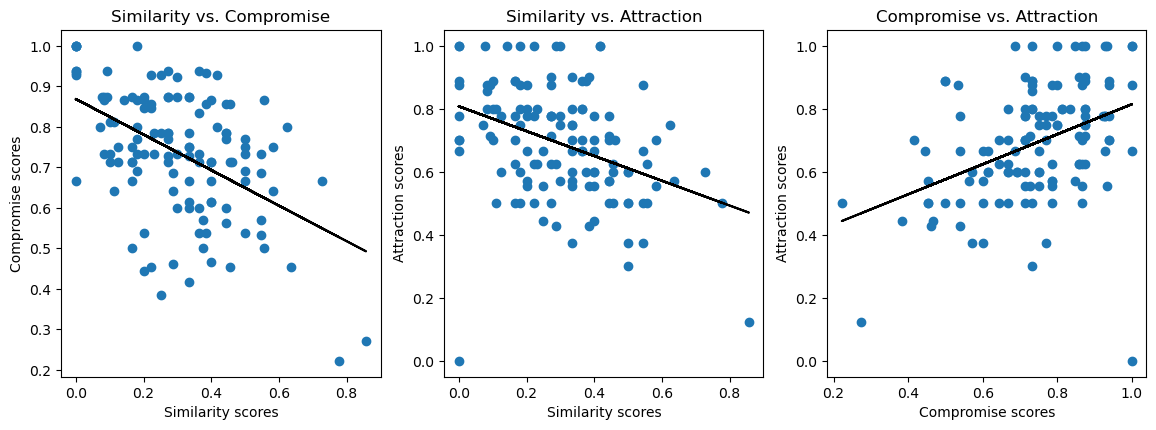

In [30]:
fig, ax = plt.subplots(1, 3, figsize=(14, 4.5))

ax[0].scatter(all_classic_decoys_df["Similarity"], all_classic_decoys_df["Compromise"])
a_0, b_0 = np.polyfit(np.array(all_classic_decoys_df["Similarity"]).flatten(), np.array(all_classic_decoys_df["Compromise"]).flatten(), 1)
ax[0].plot(all_classic_decoys_df["Similarity"], a_0*all_classic_decoys_df["Similarity"]+b_0, color='black')  
ax[0].set_xlabel("Similarity scores")
ax[0].set_ylabel("Compromise scores")
ax[0].set_title("Similarity vs. Compromise")

ax[1].scatter(all_classic_decoys_df["Similarity"], all_classic_decoys_df["Attraction"])
a_1, b_1 = np.polyfit(np.array(all_classic_decoys_df["Similarity"]).flatten(), np.array(all_classic_decoys_df["Attraction"]).flatten(), 1)
ax[1].plot(all_classic_decoys_df["Similarity"], a_1*all_classic_decoys_df["Similarity"]+b_1, color='black')  
ax[1].set_xlabel("Similarity scores")
ax[1].set_ylabel("Attraction scores")
ax[1].set_title("Similarity vs. Attraction")

ax[2].scatter(all_classic_decoys_df["Compromise"], all_classic_decoys_df["Attraction"])
a_2, b_2 = np.polyfit(np.array(all_classic_decoys_df["Compromise"]).flatten(), np.array(all_classic_decoys_df["Attraction"]).flatten(), 1)
ax[2].plot(all_classic_decoys_df["Compromise"], a_2*all_classic_decoys_df["Compromise"]+b_2, color='black')  
ax[2].set_xlabel("Compromise scores")
ax[2].set_ylabel("Attraction scores")
ax[2].set_title("Compromise vs. Attraction")


## RT and Classic Decoys


In [92]:
all_classic_decoys_df["Mean_RT (sec)"] = group_rt_df["Mean_RT (sec)"]
all_classic_decoys_df["Mean_RT_A"] = group_rt_df["Mean_RT_A"]
all_classic_decoys_df["Mean_RT_C"] = group_rt_df["Mean_RT_C"]
all_classic_decoys_df["Mean_RT_S"] = group_rt_df["Mean_RT_S"]
all_classic_decoys_df.head()


,Similarity,Compromise,Attraction,Mean_RT (sec),Mean_RT_A,Mean_RT_C,Mean_RT_S
0,0.000000,0.928571,0.777778,0.56,0.50,0.58,0.56
1,0.400000,0.466667,0.444444,1.36,1.46,1.34,1.36
2,0.181818,0.692308,0.600000,0.90,0.69,0.70,0.90
3,0.230769,0.785714,0.625000,1.47,1.64,1.78,1.47
4,0.363636,0.937500,0.700000,0.84,0.70,1.08,0.84


In [101]:
# Participant 25 had an extremely long RT 22.3, so outlier...

all_classic_decoys_df2 = all_classic_decoys_df.drop([25, 42])
all_classic_decoys_df2 = all_classic_decoys_df2.reset_index(drop=True)

#all_classic_decoys_df2[0:50]
all_classic_decoys_df2.head()

,Similarity,Compromise,Attraction,Mean_RT (sec),Mean_RT_A,Mean_RT_C,Mean_RT_S
0,0.000000,0.928571,0.777778,0.56,0.50,0.58,0.56
1,0.400000,0.466667,0.444444,1.36,1.46,1.34,1.36
2,0.181818,0.692308,0.600000,0.90,0.69,0.70,0.90
3,0.230769,0.785714,0.625000,1.47,1.64,1.78,1.47
4,0.363636,0.937500,0.700000,0.84,0.70,1.08,0.84


### Removing Outliers

Text(0.5, 1.0, 'Compromise & RT')

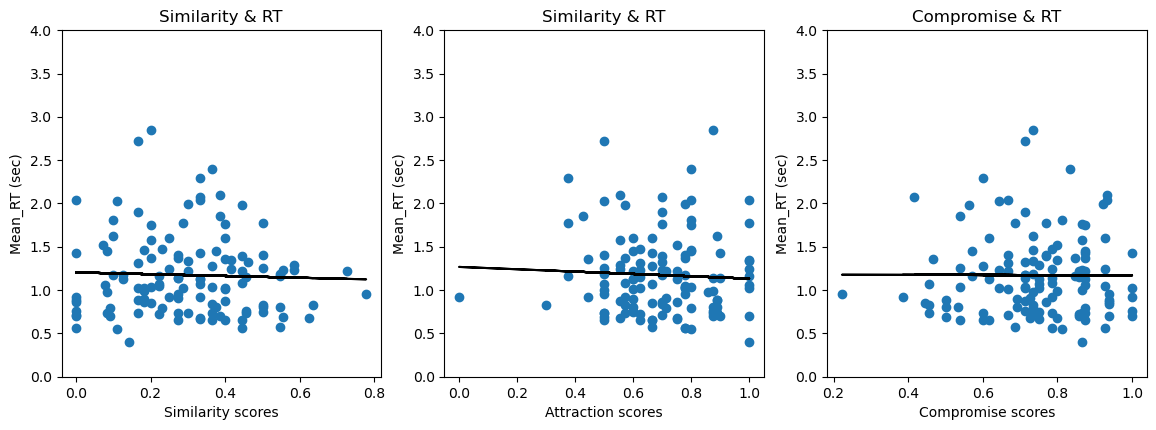

In [81]:
fig, ax = plt.subplots(1, 3, figsize=(14, 4.5))

ax[0].scatter(all_classic_decoys_df2["Similarity"], all_classic_decoys_df2["Mean_RT (sec)"])
a_0, b_0 = np.polyfit(np.array(all_classic_decoys_df2["Similarity"]).flatten(), np.array(all_classic_decoys_df2["Mean_RT (sec)"]).flatten(), 1)
ax[0].plot(all_classic_decoys_df2["Similarity"], a_0*all_classic_decoys_df2["Similarity"]+b_0, color='black')  
#ax[0].ylim(0, 5)
ax[0].set_ylim([0, 4])
ax[0].set_xlabel("Similarity scores")
ax[0].set_ylabel("Mean_RT (sec)")
ax[0].set_title("Similarity & RT")

ax[1].scatter(all_classic_decoys_df2["Attraction"], all_classic_decoys_df2["Mean_RT (sec)"])
a_1, b_1 = np.polyfit(np.array(all_classic_decoys_df2["Attraction"]).flatten(), np.array(all_classic_decoys_df2["Mean_RT (sec)"]).flatten(), 1)
ax[1].plot(all_classic_decoys_df2["Attraction"], a_1*all_classic_decoys_df2["Attraction"]+b_1, color='black')  
ax[1].set_ylim([0, 4])
ax[1].set_xlabel("Attraction scores")
ax[1].set_ylabel("Mean_RT (sec)")
ax[1].set_title("Similarity & RT")

ax[2].scatter(all_classic_decoys_df2["Compromise"], all_classic_decoys_df2["Mean_RT (sec)"])
a_2, b_2 = np.polyfit(np.array(all_classic_decoys_df2["Compromise"]).flatten(), np.array(all_classic_decoys_df2["Mean_RT (sec)"]).flatten(), 1)
ax[2].plot(all_classic_decoys_df2["Compromise"], a_2*all_classic_decoys_df2["Compromise"]+b_2, color='black')  
ax[2].set_ylim([0, 4])
ax[2].set_xlabel("Compromise scores")
ax[2].set_ylabel("Mean_RT (sec)")
ax[2].set_title("Compromise & RT")


### Including outliers

Text(0.5, 1.0, 'Compromise & RT')

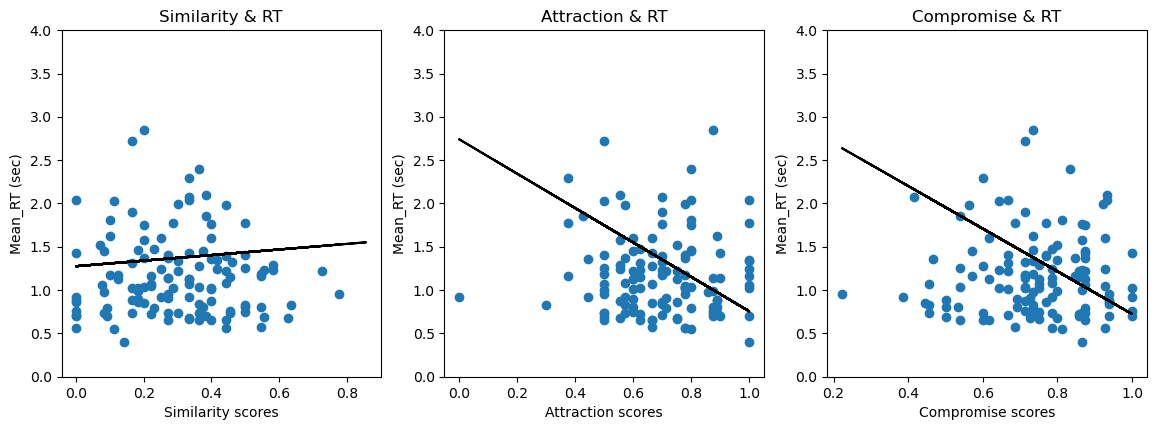

In [82]:
fig, ax = plt.subplots(1, 3, figsize=(14, 4.5))

ax[0].scatter(all_classic_decoys_df["Similarity"], all_classic_decoys_df["Mean_RT (sec)"])
a_0, b_0 = np.polyfit(np.array(all_classic_decoys_df["Similarity"]).flatten(), np.array(all_classic_decoys_df["Mean_RT (sec)"]).flatten(), 1)
ax[0].plot(all_classic_decoys_df["Similarity"], a_0*all_classic_decoys_df["Similarity"]+b_0, color='black')  
#ax[0].ylim(0, 5)
ax[0].set_ylim([0, 4])
ax[0].set_xlabel("Similarity scores")
ax[0].set_ylabel("Mean_RT (sec)")
ax[0].set_title("Similarity & RT")

ax[1].scatter(all_classic_decoys_df["Attraction"], all_classic_decoys_df["Mean_RT (sec)"])
a_1, b_1 = np.polyfit(np.array(all_classic_decoys_df["Attraction"]).flatten(), np.array(all_classic_decoys_df["Mean_RT (sec)"]).flatten(), 1)
ax[1].plot(all_classic_decoys_df["Attraction"], a_1*all_classic_decoys_df["Attraction"]+b_1, color='black')  
ax[1].set_ylim([0, 4])
ax[1].set_xlabel("Attraction scores")
ax[1].set_ylabel("Mean_RT (sec)")
ax[1].set_title("Attraction & RT")

ax[2].scatter(all_classic_decoys_df["Compromise"], all_classic_decoys_df["Mean_RT (sec)"])
a_2, b_2 = np.polyfit(np.array(all_classic_decoys_df["Compromise"]).flatten(), np.array(all_classic_decoys_df["Mean_RT (sec)"]).flatten(), 1)
ax[2].plot(all_classic_decoys_df["Compromise"], a_2*all_classic_decoys_df["Compromise"]+b_2, color='black')  
ax[2].set_ylim([0, 4])
ax[2].set_xlabel("Compromise scores")
ax[2].set_ylabel("Mean_RT (sec)")
ax[2].set_title("Compromise & RT")

## Individual Trial Type RT and Classic Decoys


Text(0.5, 1.0, 'Compromise & RT')

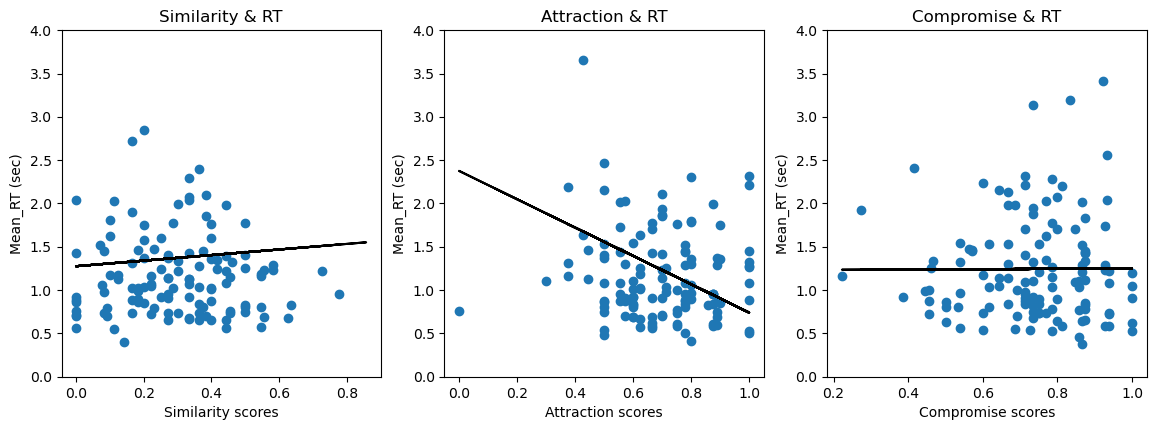

In [93]:
fig, ax = plt.subplots(1, 3, figsize=(14, 4.5))

ax[0].scatter(all_classic_decoys_df["Similarity"], all_classic_decoys_df["Mean_RT_S"])
a_0, b_0 = np.polyfit(np.array(all_classic_decoys_df["Similarity"]).flatten(), np.array(all_classic_decoys_df["Mean_RT_S"]).flatten(), 1)
ax[0].plot(all_classic_decoys_df["Similarity"], a_0*all_classic_decoys_df["Similarity"]+b_0, color='black')  
#ax[0].ylim(0, 5)
ax[0].set_ylim([0, 4])
ax[0].set_xlabel("Similarity scores")
ax[0].set_ylabel("Mean_RT (sec)")
ax[0].set_title("Similarity & RT")

ax[1].scatter(all_classic_decoys_df["Attraction"], all_classic_decoys_df["Mean_RT_A"])
a_1, b_1 = np.polyfit(np.array(all_classic_decoys_df["Attraction"]).flatten(), np.array(all_classic_decoys_df["Mean_RT_A"]).flatten(), 1)
ax[1].plot(all_classic_decoys_df["Attraction"], a_1*all_classic_decoys_df["Attraction"]+b_1, color='black')  
ax[1].set_ylim([0, 4])
ax[1].set_xlabel("Attraction scores")
ax[1].set_ylabel("Mean_RT (sec)")
ax[1].set_title("Attraction & RT")

ax[2].scatter(all_classic_decoys_df["Compromise"], all_classic_decoys_df["Mean_RT_C"])
a_2, b_2 = np.polyfit(np.array(all_classic_decoys_df["Compromise"]).flatten(), np.array(all_classic_decoys_df["Mean_RT_C"]).flatten(), 1)
ax[2].plot(all_classic_decoys_df["Compromise"], a_2*all_classic_decoys_df["Compromise"]+b_2, color='black')  
ax[2].set_ylim([0, 4])
ax[2].set_xlabel("Compromise scores")
ax[2].set_ylabel("Mean_RT (sec)")
ax[2].set_title("Compromise & RT")

Text(0.5, 1.0, 'Compromise & RT')

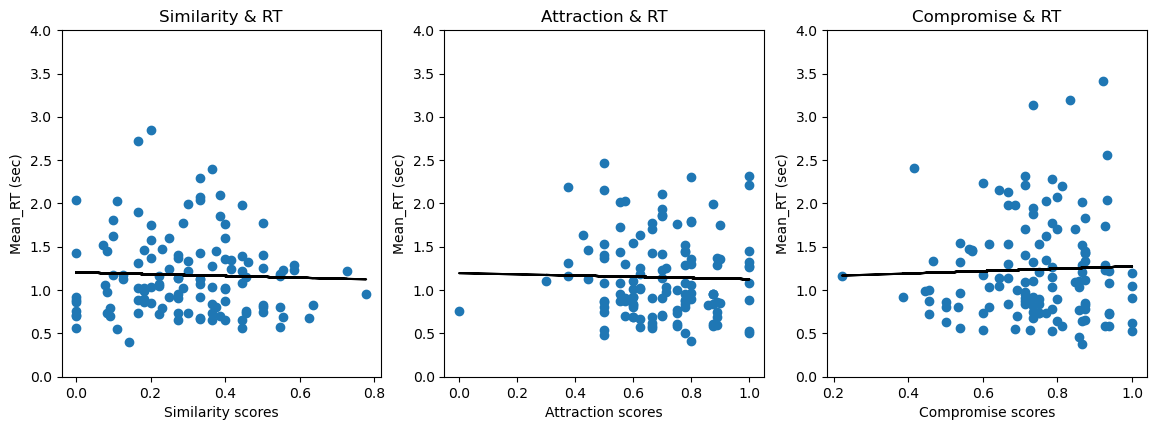

In [102]:
fig, ax = plt.subplots(1, 3, figsize=(14, 4.5))

ax[0].scatter(all_classic_decoys_df2["Similarity"], all_classic_decoys_df2["Mean_RT_S"])
a_0, b_0 = np.polyfit(np.array(all_classic_decoys_df2["Similarity"]).flatten(), np.array(all_classic_decoys_df2["Mean_RT_S"]).flatten(), 1)
ax[0].plot(all_classic_decoys_df2["Similarity"], a_0*all_classic_decoys_df2["Similarity"]+b_0, color='black')  
#ax[0].ylim(0, 5)
ax[0].set_ylim([0, 4])
ax[0].set_xlabel("Similarity scores")
ax[0].set_ylabel("Mean_RT (sec)")
ax[0].set_title("Similarity & RT")

ax[1].scatter(all_classic_decoys_df2["Attraction"], all_classic_decoys_df2["Mean_RT_A"])
a_1, b_1 = np.polyfit(np.array(all_classic_decoys_df2["Attraction"]).flatten(), np.array(all_classic_decoys_df2["Mean_RT_A"]).flatten(), 1)
ax[1].plot(all_classic_decoys_df2["Attraction"], a_1*all_classic_decoys_df2["Attraction"]+b_1, color='black')  
ax[1].set_ylim([0, 4])
ax[1].set_xlabel("Attraction scores")
ax[1].set_ylabel("Mean_RT (sec)")
ax[1].set_title("Attraction & RT")

ax[2].scatter(all_classic_decoys_df2["Compromise"], all_classic_decoys_df2["Mean_RT_C"])
a_2, b_2 = np.polyfit(np.array(all_classic_decoys_df2["Compromise"]).flatten(), np.array(all_classic_decoys_df2["Mean_RT_C"]).flatten(), 1)
ax[2].plot(all_classic_decoys_df2["Compromise"], a_2*all_classic_decoys_df2["Compromise"]+b_2, color='black')  
ax[2].set_ylim([0, 4])
ax[2].set_xlabel("Compromise scores")
ax[2].set_ylabel("Mean_RT (sec)")
ax[2].set_title("Compromise & RT")

In [103]:
# Participant 25 had an extremely long RT 22.3, so outlier...

#all_classic_decoys_df2 = all_classic_decoys_df.drop([25, 42])
#all_classic_decoys_df2 = all_classic_decoys_df2.reset_index(drop=True)
#all_classic_decoys_df2[0:50]
#all_classic_decoys_df["Mean_RT_A"].max()

## PCA Analysis on Classical Decoys

In [31]:
pca = PCA(n_components=2)

principalComponents = pca.fit_transform(all_classic_decoys_df)

print(pca.explained_variance_ratio_)
print(sum(pca.explained_variance_ratio_))

[0.61862228 0.22723892]
0.8458611912646627


In [32]:
pca.components_

array([[ 0.60252063, -0.51315567, -0.61126111],
       [-0.59823747,  0.2165733 , -0.7714972 ]])

In [33]:
all_classic_decoys_df.to_csv('/Users/luisalvarez/Documents/Decoy/22AY_01_Code/classic_decoys_scores.csv', index=False)
all_classic_decoys_df.head()

,Similarity,Compromise,Attraction
0,0.000000,0.928571,0.777778
1,0.400000,0.466667,0.444444
2,0.181818,0.692308,0.600000
3,0.230769,0.785714,0.625000
4,0.363636,0.937500,0.700000


In [34]:
all_classic_decoys_with_PC_df = all_classic_decoys_df.copy()

all_classic_decoys_with_PC_df["Phantoms"] = group_sim_freq_with_condition_df.PhantomCondition

all_classic_decoys_with_PC_df.to_csv('/Users/luisalvarez/Documents/Decoy/22AY_01_Code/classic_decoys_scores_with_Phantoms.csv', index=False)

all_classic_decoys_with_PC_df.head()


,Similarity,Compromise,Attraction,Phantoms
0,0.000000,0.928571,0.777778,Highly_desirable
1,0.400000,0.466667,0.444444,Highly_desirable
2,0.181818,0.692308,0.600000,Undesirable
3,0.230769,0.785714,0.625000,Weakly_desirable
4,0.363636,0.937500,0.700000,Weakly_desirable


## Mediation Analysis on Classical Decoys

### Mediation Analysis (Attraction -> Compromise; M=Similarity)

In [35]:
# Does Similarity mediate the relationship between Attraction-Compromise?

mediation_analysis(data=all_classic_decoys_df, x='Attraction', m='Similarity', y='Compromise', 
                   alpha=0.05, n_boot=100)


,path,coef,se,pval,CI[2.5%],CI[97.5%],sig
0,Similarity ~ X,-0.369963,0.080805,1.129530e-05,-0.529911,-0.210015,Yes
1,Y ~ Similarity,-0.438731,0.070402,6.710526e-09,-0.578088,-0.299375,Yes
2,Total,0.359596,0.071265,1.579485e-06,0.218532,0.500661,Yes
3,Direct,0.230904,0.071138,1.511817e-03,0.090079,0.371730,Yes
4,Indirect,0.128692,0.050486,0.000000e+00,0.044650,0.223816,Yes


### Mediation Analysis (Attraction -> Similarity; M=Compromise)


In [36]:
mediation_analysis(data=all_classic_decoys_df, x='Attraction', m='Compromise', y='Similarity', 
                   alpha=0.05, n_boot=100)

,path,coef,se,pval,CI[2.5%],CI[97.5%],sig
0,Compromise ~ X,0.359596,0.071265,1.579485e-06,0.218532,0.500661,Yes
1,Y ~ Compromise,-0.546961,0.087769,6.710526e-09,-0.720695,-0.373228,Yes
2,Total,-0.369963,0.080805,1.129530e-05,-0.529911,-0.210015,Yes
3,Direct,-0.209146,0.081912,1.190274e-02,-0.371299,-0.046994,Yes
4,Indirect,-0.160817,0.051268,0.000000e+00,-0.275138,-0.072268,Yes


### Mediation Analysis (Similarity -> Compromise; M=Attraction)


In [37]:
mediation_analysis(data=all_classic_decoys_df, x='Similarity', m='Attraction', y='Compromise', 
                   alpha=0.05, n_boot=100)

,path,coef,se,pval,CI[2.5%],CI[97.5%],sig
0,Attraction ~ X,-0.393582,0.085963,1.129530e-05,-0.563741,-0.223423,Yes
1,Y ~ Attraction,0.359596,0.071265,1.579485e-06,0.218532,0.500661,Yes
2,Total,-0.438731,0.070402,6.710526e-09,-0.578088,-0.299375,Yes
3,Direct,-0.347852,0.073374,5.823384e-06,-0.493103,-0.202600,Yes
4,Indirect,-0.090880,0.059338,2.000000e-02,-0.212172,-0.008589,Yes


### Mediation Analysis (Similarity -> Attraction; M=Compromise)


In [38]:
mediation_analysis(data=all_classic_decoys_df, x='Similarity', m='Compromise', y='Attraction', 
                   alpha=0.05, n_boot=100)

,path,coef,se,pval,CI[2.5%],CI[97.5%],sig
0,Compromise ~ X,-0.438731,0.070402,6.710526e-09,-0.578088,-0.299375,Yes
1,Y ~ Compromise,0.476925,0.094517,1.579485e-06,0.289834,0.664016,Yes
2,Total,-0.393582,0.085963,1.129530e-05,-0.563741,-0.223423,Yes
3,Direct,-0.242543,0.094991,1.190274e-02,-0.430588,-0.054497,Yes
4,Indirect,-0.151039,0.049444,0.000000e+00,-0.261328,-0.061330,Yes


### Mediation Analysis (Compromise -> Attraction; M=Similarity)


In [39]:
mediation_analysis(data=all_classic_decoys_df, x='Compromise', m='Similarity', y='Attraction', 
                   alpha=0.05, n_boot=100)

,path,coef,se,pval,CI[2.5%],CI[97.5%],sig
0,Similarity ~ X,-0.546961,0.087769,6.710526e-09,-0.720695,-0.373228,Yes
1,Y ~ Similarity,-0.393582,0.085963,1.129530e-05,-0.563741,-0.223423,Yes
2,Total,0.476925,0.094517,1.579485e-06,0.289834,0.664016,Yes
3,Direct,0.344264,0.106063,1.511817e-03,0.134302,0.554226,Yes
4,Indirect,0.132661,0.054940,2.000000e-02,0.065513,0.266812,Yes


### Mediation Analysis (Compromise -> Similarity; M=Attraction)


In [40]:
mediation_analysis(data=all_classic_decoys_df, x='Compromise', m='Attraction', y='Similarity', 
                   alpha=0.05, n_boot=100)

,path,coef,se,pval,CI[2.5%],CI[97.5%],sig
0,Attraction ~ X,0.476925,0.094517,1.579485e-06,0.289834,0.664016,Yes
1,Y ~ Attraction,-0.369963,0.080805,1.129530e-05,-0.529911,-0.210015,Yes
2,Total,-0.546961,0.087769,6.710526e-09,-0.720695,-0.373228,Yes
3,Direct,-0.447214,0.094333,5.823384e-06,-0.633956,-0.260473,Yes
4,Indirect,-0.099747,0.066050,0.000000e+00,-0.253352,-0.006013,Yes


# Creating Figures

In [41]:
#ad_dataset("titanic")
#sns.catplot(data=titanic, x="sex", y="survived", hue="class", kind="bar")

In [42]:
# Declaring means for each decoy
#sns_y_att = np.array([target_A_mean, competitor_A_mean, decoy_A_mean])
sns_y_att = np.array([decoy_A_mean, competitor_A_mean, target_A_mean])
sns_error_att = np.array([target_A_sem, competitor_A_sem, decoy_A_sem])

sns_y_com = np.array([decoy_C_mean, competitor_C_mean, target_C_mean])
sns_error_com = np.array([target_C_sem, competitor_C_sem, decoy_C_sem])

sns_y_sim = np.array([decoy_S_mean, competitor_S_mean, target_S_mean])
sns_error_sim = np.array([target_S_sem, competitor_S_sem, decoy_S_sem])

#y_lim = [0, 70]


#f, axs = plt.subplots(1, 2, figsize=(8, 4), gridspec_kw=dict(width_ratios=[4, 3]))
#sns.scatterplot(data=penguins, x="flipper_length_mm", y="bill_length_mm", hue="species", ax=axs[0])
#sns.histplot(data=penguins, x="species", hue="species", shrink=.8, alpha=.8, legend=False, ax=axs[1])
#f.tight_layout()

In [43]:
target_A_mean

61.28

[[ 0.   23.49]
 [ 1.   22.57]
 [ 2.   53.94]]


Text(0.5, 1.0, 'Similarity')

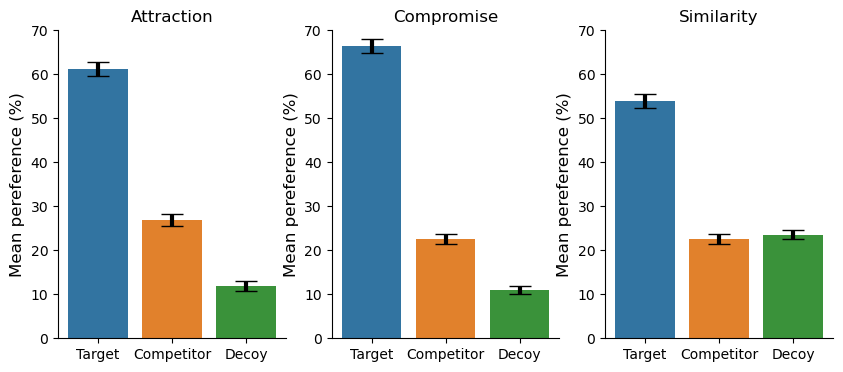

In [44]:
fig, ax = plt.subplots(1, 3, figsize=(10, 4))

y_lim = [0, 70] # decide later whether this is the same for all decoys or if we use one specific for each.

# Attraction Decoy fig ax[0]
PNBar_att = sns.barplot(x=sns_error_att, y=sns_y_att, ci=None, order=None, ax=ax[0])

PNBar_att.set(ylim=y_lim)
    
xys = np.array([[0, sns_y_att[0]], [1, sns_y_att[1]], [2, sns_y_att[2]]])

PNBar_att.errorbar(x=xys[:, 0], y=[61.28, 26.88, 11.84], yerr=sns_error_att, ls='', lw=3, color='black', capsize=8)
    
sns.despine()
ax[0].set_xlabel("")
    
ax[0].set_ylabel('Mean pereference (%)', size=12)
ax[0].set_xticklabels(labels=["Target", "Competitor", "Decoy"], fontsize=10)
ax[0].set_title('Attraction')

# Compromise Decoy fig ax[1]
PNBar_com = sns.barplot(x=sns_error_com, y=sns_y_com, ci=None, order=None, ax=ax[1])

PNBar_com.set(ylim=y_lim)
    
xys = np.array([[0, sns_y_com[0]], [1, sns_y_com[1]], [2, sns_y_com[2]]])

PNBar_com.errorbar(x=xys[:, 0], y=[66.4, 22.6, 11], yerr=sns_error_com, ls='', lw=3, color='black', capsize=8)
    
sns.despine()
ax[1].set_xlabel("")
    
ax[1].set_ylabel('Mean pereference (%)', size=12)
ax[1].set_xticklabels(labels=["Target", "Competitor", "Decoy"], fontsize=10)
ax[1].set_title('Compromise')

# Similarity Decoy fig ax[2]
PNBar_sim = sns.barplot(x=sns_error_sim, y=sns_y_sim, ci=None, order=None, ax=ax[2])

PNBar_sim.set(ylim=y_lim)
    
xys = np.array([[0, sns_y_sim[0]], [1, sns_y_sim[1]], [2, sns_y_sim[2]]])
print(xys)

PNBar_sim.errorbar(x=xys[:, 0], y=[53.94, 22.57, 23.49], yerr=sns_error_sim, ls='', lw=3, color='black', capsize=8)
    
sns.despine()
ax[2].set_xlabel("")
    
ax[2].set_ylabel('Mean pereference (%)', size=12)
ax[2].set_xticklabels(labels=["Target", "Competitor", "Decoy"], fontsize=10)
ax[2].set_title('Similarity')


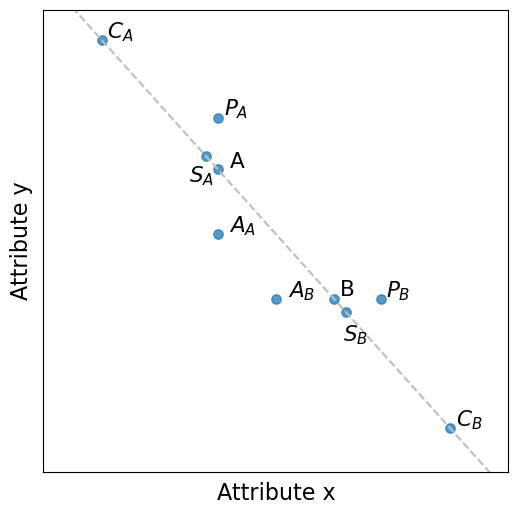

In [45]:
x = np.array([14, 16, 14, 16.8, 14, 15, 13.8, 16.2, 12, 18])
y = np.array([18, 12, 20.4, 12, 15, 12, 18.6, 11.4, 24, 6])

x1 = np.array([0, 20])

y1 = np.array([60, 0])

fig, ax = plt.subplots(figsize=(6, 6))

ax.scatter(x, y, s=45, alpha=.75)
ax.annotate("A", (x[0]+.2, y[0]+.1), size=15.5)
ax.annotate("B", (x[1]+.1, y[1]+.15), size=15.5)
ax.annotate("$P_{A}$", (x[2]+.1, y[2]+.1), size=15.5)
ax.annotate("$P_{B}$", (x[3]+.1, y[3]+.1), size=15.5)
ax.annotate("$A_{A}$", (x[4]+.2, y[4]+.1), size=15.5)
ax.annotate("$A_{B}$", (x[5]+.2, y[5]+.1), size=15.5)
ax.annotate("$S_{A}$", (x[6]-.3, y[6]-1.2), size=15.5)
ax.annotate("$S_{B}$", (x[7]-.05, y[7]-1.35), size=15.5)
ax.annotate("$C_{A}$", (x[8]+.1, y[8]+.1), size=15.5)
ax.annotate("$C_{B}$", (x[9]+.1, y[9]+.1), size=15.5)
ax.plot(x1, y1, color='0.75', linestyle='dashed')

ax.set_xlim(11, 19)
ax.set_ylim(4, 25.4)
ax.set_xticks([])
ax.set_yticks([])
ax.set_ylabel('Attribute y', size=16)
ax.set_xlabel('Attribute x', size=16)
plt.show()




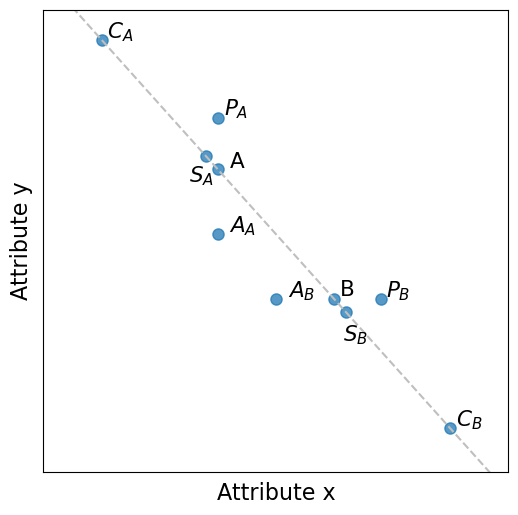

In [46]:
x = np.array([14, 16, 14, 16.8, 14, 15, 13.8, 16.2, 12, 18])
y = np.array([18, 12, 20.4, 12, 15, 12, 18.6, 11.4, 24, 6])

x1 = np.array([0, 20])

y1 = np.array([60, 0])

fig, ax = plt.subplots(figsize=(6, 6))

ax.scatter(x, y, s=65, alpha=.75)
ax.annotate("A", (x[0]+.2, y[0]+.1), size=15.5)
ax.annotate("B", (x[1]+.1, y[1]+.15), size=15.5)
ax.annotate("$P_{A}$", (x[2]+.1, y[2]+.1), size=15.5)
ax.annotate("$P_{B}$", (x[3]+.1, y[3]+.1), size=15.5)
ax.annotate("$A_{A}$", (x[4]+.2, y[4]+.1), size=15.5)
ax.annotate("$A_{B}$", (x[5]+.2, y[5]+.1), size=15.5)
ax.annotate("$S_{A}$", (x[6]-.3, y[6]-1.2), size=15.5)
ax.annotate("$S_{B}$", (x[7]-.05, y[7]-1.35), size=15.5)
ax.annotate("$C_{A}$", (x[8]+.1, y[8]+.1), size=15.5)
ax.annotate("$C_{B}$", (x[9]+.1, y[9]+.1), size=15.5)
ax.plot(x1, y1, color='0.75', linestyle='dashed')

ax.set_xlim(11, 19)
ax.set_ylim(4, 25.4)
ax.set_xticks([])
ax.set_yticks([])
ax.set_ylabel('Attribute y', size=16)
ax.set_xlabel('Attribute x', size=16)
plt.show()

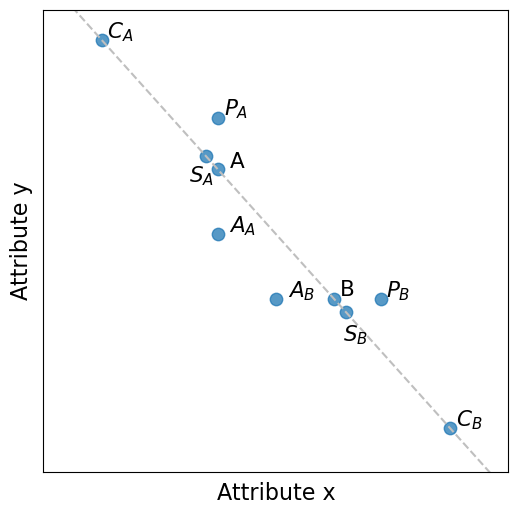

In [47]:
x = np.array([14, 16, 14, 16.8, 14, 15, 13.8, 16.2, 12, 18])
y = np.array([18, 12, 20.4, 12, 15, 12, 18.6, 11.4, 24, 6])

x1 = np.array([0, 20])

y1 = np.array([60, 0])

fig, ax = plt.subplots(figsize=(6, 6))

ax.scatter(x, y, s=80, alpha=.75)
ax.annotate("A", (x[0]+.2, y[0]+.1), size=15.5)
ax.annotate("B", (x[1]+.1, y[1]+.15), size=15.5)
ax.annotate("$P_{A}$", (x[2]+.1, y[2]+.1), size=15.5)
ax.annotate("$P_{B}$", (x[3]+.1, y[3]+.1), size=15.5)
ax.annotate("$A_{A}$", (x[4]+.2, y[4]+.1), size=15.5)
ax.annotate("$A_{B}$", (x[5]+.2, y[5]+.1), size=15.5)
ax.annotate("$S_{A}$", (x[6]-.3, y[6]-1.2), size=15.5)
ax.annotate("$S_{B}$", (x[7]-.05, y[7]-1.35), size=15.5)
ax.annotate("$C_{A}$", (x[8]+.1, y[8]+.1), size=15.5)
ax.annotate("$C_{B}$", (x[9]+.1, y[9]+.1), size=15.5)
ax.plot(x1, y1, color='0.75', linestyle='dashed')

ax.set_xlim(11, 19)
ax.set_ylim(4, 25.4)
ax.set_xticks([])
ax.set_yticks([])
ax.set_ylabel('Attribute y', size=16)
ax.set_xlabel('Attribute x', size=16)
plt.show()

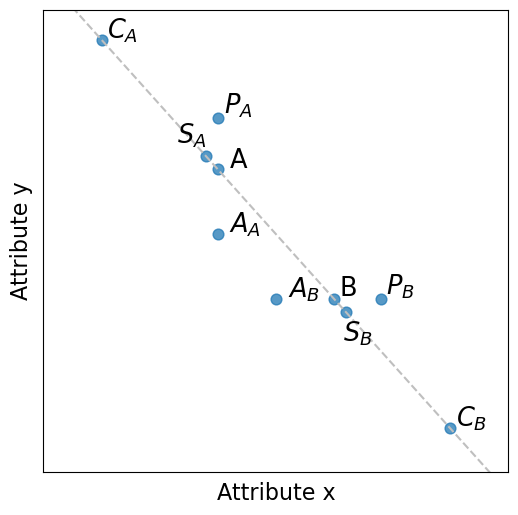

In [48]:
x = np.array([14, 16, 14, 16.8, 14, 15, 13.8, 16.2, 12, 18])
y = np.array([18, 12, 20.4, 12, 15, 12, 18.6, 11.4, 24, 6])

x1 = np.array([0, 20])

y1 = np.array([60, 0])

fig, ax = plt.subplots(figsize=(6, 6))

ax.scatter(x, y, s=60, alpha=.75)
ax.annotate("A", (x[0]+.2, y[0]+.1), size=18.5)
ax.annotate("B", (x[1]+.1, y[1]+.15), size=18.5)
ax.annotate("$P_{A}$", (x[2]+.1, y[2]+.2), size=18.5)
ax.annotate("$P_{B}$", (x[3]+.1, y[3]+.2), size=18.5)
ax.annotate("$A_{A}$", (x[4]+.2, y[4]+.1), size=18.5)
ax.annotate("$A_{B}$", (x[5]+.2, y[5]+.1), size=18.5)
ax.annotate("$S_{A}$", (x[6]-.5, y[6]+.6), size=18.5)
ax.annotate("$S_{B}$", (x[7]-.05, y[7]-1.35), size=18.5)
ax.annotate("$C_{A}$", (x[8]+.1, y[8]+.1), size=18.5)
ax.annotate("$C_{B}$", (x[9]+.1, y[9]+.1), size=18.5)
ax.plot(x1, y1, color='0.75', linestyle='dashed')

ax.set_xlim(11, 19)
ax.set_ylim(4, 25.4)
ax.set_xticks([])
ax.set_yticks([])
ax.set_ylabel('Attribute y', size=16)
ax.set_xlabel('Attribute x', size=16)
plt.show()

In [49]:
group_att_freq_with_condition_df

,PID,Target(num),Competitor(num),Att_Decoy(num),Target(%),Competitor(%),Att_Decoy(%),Target_perc,Competitor_perc,PhantomCondition,CouplingCondition
0,40781,7,2,1,NaN,NaN,10.0,70.0,20.0,Highly_desirable,High coupling
1,40447,4,5,1,NaN,NaN,10.0,40.0,50.0,Highly_desirable,Low coupling
2,41454,6,4,0,NaN,NaN,0.0,60.0,40.0,Undesirable,Low coupling
3,34796,5,3,2,NaN,NaN,20.0,50.0,30.0,Weakly_desirable,Low coupling
4,44066,7,3,0,NaN,NaN,0.0,70.0,30.0,Weakly_desirable,High coupling
...,...,...,...,...,...,...,...,...,...,...,...
120,44089,5,4,1,NaN,NaN,10.0,50.0,40.0,Highly_desirable,High coupling
121,31535,7,3,0,NaN,NaN,0.0,70.0,30.0,Highly_desirable,Low coupling
122,37897,5,5,0,NaN,NaN,0.0,50.0,50.0,Weakly_desirable,Low coupling
123,42986,7,1,2,NaN,NaN,20.0,70.0,10.0,Highly_desirable,High coupling
